# Mooring Data from the Rocakall Trough
EB1, WB1 & WB2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
import xarray as xr
import pandas as pd
import os
import gsw
from pathlib import Path
import re

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Load data

In [4]:
data_path = Path('../../Data/SAMS_moorings/') 
# data_path =  Path('./data/')

# moor = 'rtwb1'
# moor = 'rtwb2'
moor = 'rteb1'

In [5]:
def load_moor_data(data_path,moor,year):
    def __dms2dd(degrees, minutes, direction):
        dd = float(degrees) + float(minutes)/60;
        if direction == 'W' or direction == 'S':
            dd *= -1
        return dd;
    
    def __depth_func(value_chosen,moor):

        minimum = float("inf")
        if moor == 'rteb1':
            setted_list = [50, 75, 100, 250, 500, 750,755,950,1000, 1250, 1500,1600, 1775]
        else:
            setted_list = [50, 75, 100, 250, 500, 750, 1000, 1250, 1500, 1750]
        for val in setted_list:
            if abs(val - value_chosen) < minimum:
               final_value = float(val)
               minimum = abs(val - value_chosen)
        return final_value

    def __read_header(file,moor):

        with open(file) as myfile:
            head = [next(myfile) for x in range(10)]
            attr_str={}
            coord_str={}
            for line in head:
                info = re.split('[ \n]+',line)
                if info[0]=='Latitude' or info[0]=='Longitude':
                    attr_str[info[0]] = __dms2dd(info[2],info[3],info[4])
                elif info[0]=='InstrDepth':
                    if str(file)[-26:]=='rteb1_04_2017_007.microcat' or str(file)[-26:]=='rteb1_05_2018_006.microcat':
                        coord_str['depth'] = ('depth',[float(755)])
                    else:
                        coord_str['depth'] = ('depth',[__depth_func(float(info[2]),moor)])
                else:
                    attr_str[info[0]] = info[2]
            attr_str['Latitude_units'] = 'degrees_north'
            attr_str['Longitude_units'] = 'degrees_east'
        return attr_str,coord_str
    
    def __load_csv_as_xr(file,moor):
        attr_str = __read_header(file,moor)
        cols = ['yyyy', 'mm', 'dd', 'hh', 'temp', 'cond', 'pres']
        df = pd.read_csv(file, sep='\s+' ,parse_dates={'dates': [0,1,2,3]}, squeeze=True, 
                         header = None, skiprows = 11, names = cols, engine='python')

        for idx,dt in enumerate(df['dates']):
            date_str =dt[:4]+dt[5:7]+dt[8:10]
            df['dates'][idx]=(pd.to_datetime(date_str,format='%Y%m%d')+datetime.timedelta(hours=np.float(dt[11:])))

        ds = xr.Dataset.from_dataframe(df)
        attr_str,coord_str = __read_header(file,moor)
        ds.coords['time']=ds.dates
        ds = ds.swap_dims({'index':'time'}).drop('index').drop_vars('dates')
        ds.attrs = attr_str
        ds = ds.expand_dims('depth')
        ds = ds.assign_coords(coord_str)
        ds['sal'] = gsw.SP_from_C(ds.cond, ds.temp, ds.pres)
        ds = ds.drop_vars('cond')
        return ds

    def __get_filelist(data_path,moor,year):
        file_list = list(sorted(
            (data_path).glob(f"{moor}_??_{year}*/microcat/{moor}_*.microcat")
            ))
        return file_list

    files = __get_filelist(data_path,moor,year)
    ds = __load_csv_as_xr(files[0],moor)
    for file in files[1:]:
        ds = xr.concat([ds,__load_csv_as_xr(file,moor)],dim='depth')
    
    ds.depth.attrs['units']='m'
    
    ds.temp.attrs['standard_name'] = "sea_water_temperature" ;
    ds.temp.attrs['long_name'] = "In Situ Temperature of Sea Water" ;
    ds.temp.attrs['units'] = "degree_C" ;
    
    ds.sal.attrs['standard_name'] = "sea_water_salinity" ;
    ds.sal.attrs['long_name'] = "Practical Salinity on the PSS-78 scale" ;
    ds.sal.attrs['units'] = "unitless" ;
    
    ds.pres.attrs['standard_name'] = 'sea_water_pressure'
    ds.pres.attrs['long_name'] = 'Pressure of Sea Water'
    ds.pres.attrs['units'] = 'dbar'
        
    ds.attrs['Mooring'] = f'{moor}'
    del ds.attrs['SerialNumber']
    
    
    if moor == 'rteb1':
        setted_list = [50, 75, 100, 250, 500, 750,755,950,1000, 1250, 1500,1600, 1775]
    else:
        setted_list = [50, 75, 100, 250, 500, 750, 1000, 1250, 1500, 1750]
    for val in setted_list:
        if val not in ds.depth:
            dummy = ds.isel(depth=1)
            dummy['depth'] = val
            for var in ds.var(): dummy[var] = dummy[var]*np.nan
            ds = xr.concat([ds,dummy],dim='depth')
    
    return ds.sortby('depth')

In [6]:
# %%time
ds = load_moor_data(data_path,moor,2014)
# ds1 = load_moor_data(data_path,moor,2015)
for year in np.arange(2015,2019):
    display(year)
    ds = xr.concat([ds,load_moor_data(data_path,moor,year)],dim='time')

2015

2016

2017

2018

In [7]:
ds1D = ds.resample(time = "1D").mean(keep_attrs=True);
ds1D

<xarray.Dataset>
Dimensions:  (depth: 13, time: 2279)
Coordinates:
  * time     (time) datetime64[ns] 2014-07-18 2014-07-19 ... 2020-10-12
  * depth    (depth) float64 50.0 75.0 100.0 250.0 ... 1.5e+03 1.6e+03 1.775e+03
Data variables:
    temp     (time, depth) float64 nan 10.47 nan 9.887 ... 4.422 4.098 3.748
    pres     (time, depth) float64 nan 78.23 nan ... 1.623e+03 1.79e+03
    sal      (time, depth) float64 nan 35.39 nan 35.39 ... 34.98 34.95 34.94
Attributes:
    Mooring:          rteb1
    WaterDepth:       1800
    Start_Date:       2014/07/18
    Start_Time:       12:30
    End_Date:         2015/06/20
    End_Time:         06:30
    Latitude:         57.099333333333334
    Longitude:        -9.548
    Latitude_units:   degrees_north
    Longitude_units:  degrees_east

In [8]:
ds1D.to_netcdf(f'data/{moor}_all_merged.nc', 
        engine='netcdf4',
        encoding={'time':{'units':'days since 1900-01-01 00:00:00'}})

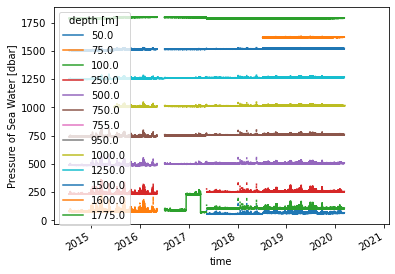

In [9]:
ds.pres.where(ds.pres>0).plot.line(x='time')